In [1]:
import scipy
import os
import numpy as np
import mne
import matplotlib.pyplot as plt

In [2]:
class Recording:
    # Data paths
    root = 'C:/Users/annej/OneDrive - NTNU/Prosjekt/Dataset/SAM40'
    dir_raw = root + '/raw_data'
    dir_filtered = root + '/ica_filtered_data'
    
    # Parameters
    Fs = 128
    ch_type = 'eeg'
    n_channels = 32
    
    def __init__(self, data_type, sub_nr, trial_nr):
        self.data_type = data_type
        self.sub_nr = sub_nr
        self.trial_nr = trial_nr
        
        # Load data
        self.load_data()
                
        # Create mne RawArray
        info = mne.create_info(ch_names = self.get_channels(), sfreq = self.Fs, ch_types = self.ch_type)
        self.raw_arr = mne.io.RawArray(self.data, info, first_samp=0, copy='auto', verbose=None)

        # Do initial filtering
        self.filt_arr = self.init_filter()
        
        # Set montage
        montage = mne.channels.make_standard_montage('standard_1020')
        self.filt_arr.set_montage(montage)   
    #----------------------------------------------------------------------------------------------------
    
    def load_data(self):
        dir = self.dir_raw
        data_key = 'Data'
            
        # Load one recording
        for filename in os.listdir(dir):
            if f"{self.data_type}_sub_{self.sub_nr}_trial{self.trial_nr}" in filename:
                f = os.path.join(dir, filename)
                self.data = scipy.io.loadmat(f)[data_key]
                break
                
                
    def save_data(self):
        title = f"{self.data_type}_sub_{self.sub_nr}_trial{self.trial_nr}"
        clean_data = self.reconst_arr.to_data_frame(scalings=1)
        clean_data = clean_data.to_numpy()
        clean_data = np.transpose(clean_data)
        clean_dict = {
            "Clean_data" : clean_data[1:, :]  #First column of dataFrames is not data
        }
        scipy.io.savemat(f'{self.root}/ica_filtered_data/{title}.mat', clean_dict)
    
    def get_channels(self):
        coordinates_file = os.path.join(self.root, "Coordinates.locs") 

        channel_names = []

        with open(coordinates_file, "r") as file:
            for line in file:
                elements = line.split()
                channel = elements[-1]
                channel_names.append(channel)
                
        return channel_names
    
    
    def init_filter(self):
        band_pass = self.raw_arr.copy().filter(1, 50)
        sav_gol = band_pass.copy().savgol_filter(h_freq=10, verbose=False)
        return sav_gol
    
    def init_ICA(self):
        self.ica = mne.preprocessing.ICA(n_components=15, max_iter=10000, random_state=97)
        self.ica.fit(self.filt_arr)
        
    def plot_sources(self):
        self.ica.plot_sources(self.filt_arr, title=f'ICA components S{self.sub_nr} T{self.trial_nr}', show_scrollbars=False)
        self.ica.plot_components(colorbar=True, reject='auto')
        
    def plot_properties(self, components):
        self.ica.plot_properties(self.filt_arr, picks = components)
        
    def test_exclude(self, components):
        self.ica.plot_overlay(self.filt_arr, exclude=components, picks='eeg')

    def exclude_ICA(self, components):
        self.ica.exclude = components
        self.reconst_arr = self.filt_arr.copy()
        self.ica.apply(self.reconst_arr)
    
    def plot(self, data_type, save=False):
        if data_type == 'ica' and save == True:
            with mne.viz.use_browser_backend('matplotlib'):
                title = f"ICA components S{self.sub_nr} T{self.trial_nr}"
                fig = self.ica.plot_sources(self.filt_arr, title=title, 
                                            show_scrollbars=False)
                fig.savefig(f'{self.root}/Figures/{title}.png') 

        else:
            if data_type == 'raw':
                data = self.raw_arr
                title = f"Raw data S{self.sub_nr} T{self.trial_nr}"
            elif data_type == 'filtered': 
                data = self.filt_arr
                title = f"Filtered data S{self.sub_nr} T{self.trial_nr}"
            elif data_type == 'reconstructed':
                data = self.reconst_arr
                title = f"Reconstructed data S{self.sub_nr} T{self.trial_nr}"
                pass

            if not save:
                data.plot(duration = 25, title=title, n_channels=self.n_channels, scalings=18, show_scrollbars=False)
            else:
                with mne.viz.use_browser_backend('matplotlib'):
                    #scalings = 18 is good
                    fig = data.plot(duration = 25, title=f'{title}', n_channels=self.n_channels, scalings=18, show_scrollbars=False)
                    fig.savefig(f'{self.root}/Figures/{title}.png') 



In [3]:
test = Recording(data_type = 'Arithmetic', sub_nr = 40, trial_nr = 3)

Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 423 samples (3.305 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    0.0s finished


In [4]:
test.plot('raw')
test.plot('filtered')

Using qt as 2D backend.


Channels marked as bad:
none
Channels marked as bad:
none


Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 16.5s.
Creating RawArray with float64 data, n_channels=15, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.


c:\Users\annej\anaconda3\envs\MachineLearning\lib\site-packages\sklearn\decomposition\_fastica.py:120: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


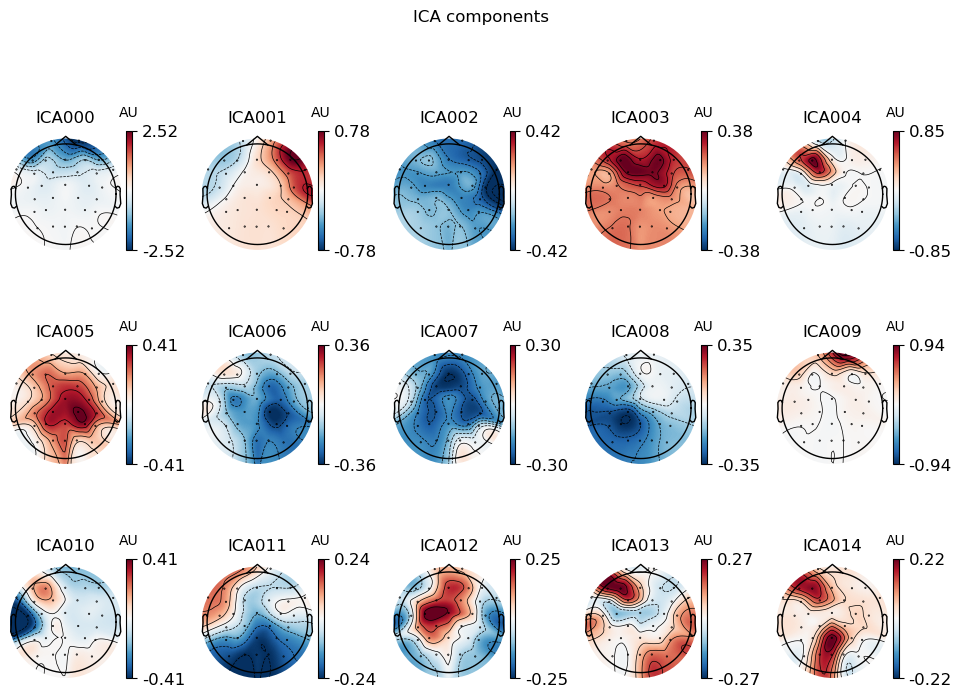

In [5]:
test.init_ICA()
test.plot_sources()

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
12 matching events found
No baseline correction applied
0 projection items activated


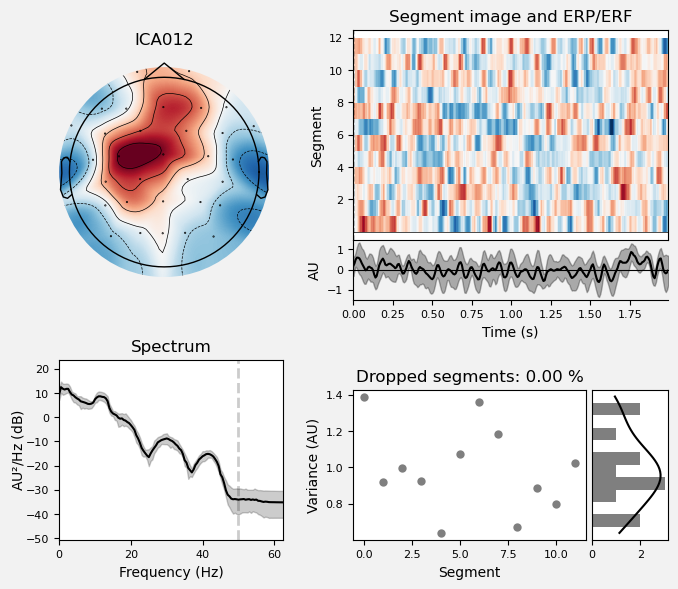

In [9]:
test.plot_properties([12])

Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 6 ICA components
    Projecting back using 32 PCA components


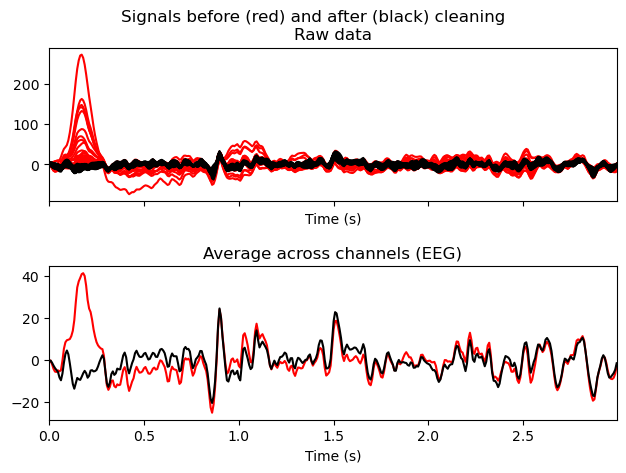

In [10]:
test.test_exclude([0,1,4,9,10,14])

In [12]:
test.exclude_ICA([0,1,4,9,10,14])
test.plot('filtered')
test.plot('reconstructed')

Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 6 ICA components
    Projecting back using 32 PCA components


Channels marked as bad:
none
Channels marked as bad:
none


In [10]:
#test.plot('raw', save=True)
#test.plot('filtered', save=True)
#test.plot('ica', save=True)
#test.plot('reconstructed', save=True)

In [754]:
test.save_data()